In [40]:
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from traitlets.config import Config
c = Config()
c.NotebookApp.iopub_msg_rate_limit = 10000.0  # or your desired value
c.NotebookApp.rate_limit_window = 15.0  # or your desired value

import warnings
warnings.filterwarnings('ignore')


# clear previous Keras session and free all resources
tf.keras.backend.clear_session()

In [41]:
import keras
from keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [42]:
import tensorflow as tf

# Get the list of available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    # Print the list of available GPUs
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU devices found.")

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
GPU: PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')


In [43]:
import pandas as pd
from tqdm import tqdm
#Dataset Preparation
train_df = pd.read_csv("../train_concepts.csv")
valid_df = pd.read_csv("../valid_concepts.csv")

In [44]:
train_folder = '../Training/'
train_paths = []

for i in range (len(train_df['ID'])):
    path = train_folder+str(train_df['ID'][i])+'.jpg'
    train_paths.append(path)
print (len(train_paths))

70108


In [45]:
train_cui = []
for i in range (len(train_df['CUIs'])):
    cui = train_df['CUIs'][i].split(';')
    train_cui.append(cui)
print (len(train_cui))

70108


In [46]:
valid_folder = '../Valid/'
valid_paths = []

for i in range (len(valid_df['ID'])):
    path = valid_folder+str(valid_df['ID'][i])+'.jpg'
    valid_paths.append(path)
print (len(valid_paths))

9972


In [47]:
valid_cui = []
for i in range (len(valid_df['CUIs'])):
    cui = valid_df['CUIs'][i].split(';')
    valid_cui.append(cui)
print (len(valid_cui))

9972


In [48]:
unique_cui = []
for i in range(len(train_cui)):
    for j in range(len(train_cui[i])):  # Use train_cui[i] instead of len(i)
        if train_cui[i][j] not in unique_cui:  # Check train_cui[i][j] instead of j
            unique_cui.append(train_cui[i][j])  # Append train_cui[i][j] instead of j
print(len(unique_cui))

1944


In [49]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=unique_cui)

In [50]:
mlb.fit(train_cui)

MultiLabelBinarizer(classes=['C0040405', 'C0041618', 'C0817096', 'C0205271',
                             'C0002978', 'C0036033', 'C1266909', 'C0225317',
                             'C0497156', 'C0030797', 'C0001304', 'C0175662',
                             'C0228160', 'C0228161', 'C0819757', 'C0019080',
                             'C0228193', 'C0240059', 'C0024485', 'C0228465',
                             'C0028259', 'C0037925', 'C0007458', 'C0444611',
                             'C0006255', 'C0037303', 'C0018817', 'C0238207',
                             'C0022646', 'C0006736', ...])

In [51]:
# transform the training labels and validation labels into binary arrays
train_labels_binarized = mlb.transform(train_cui)
valid_labels_binarized = mlb.transform(valid_cui)

In [52]:
# x_train = train_paths
# y_train = train_labels
# x_test = valid_paths
# y_test = valid_labels

In [62]:
num_classes = len(mlb.classes_)
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 2
BATCH_SIZE = 8
image_size = 192
def preprocess_image(image_path):
    # Load the image from disk
    image = tf.io.read_file(image_path)
    # Decode the image to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)
    # Randomly rotate the image by 0, 90, 180, or 270 degrees
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    #Resize the image
    image = tf.image.resize(image, (image_size,image_size))
    #image = tf.image.resize(image, (299,299))
    
    # Convert the pixel values to floats between 0 and 1
    image = tf.cast(image, tf.float32) / 255.0
    return image


train_img = tf.data.Dataset.from_tensor_slices(train_paths)
train_img = train_img.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_img = train_img.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
train_label = tf.data.Dataset.from_tensor_slices(train_labels_binarized)
train_label = train_label.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)


trainDS = tf.data.Dataset.zip((train_img,train_label))
# trainDS = trainDS.repeat()


valid_img = tf.data.Dataset.from_tensor_slices(valid_paths)
valid_img = valid_img.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
valid_img = valid_img.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
valid_label = tf.data.Dataset.from_tensor_slices(valid_labels_binarized)
valid_label = valid_label.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)


validDS = tf.data.Dataset.zip((valid_img,valid_label))
# validDS = validDS.repeat()

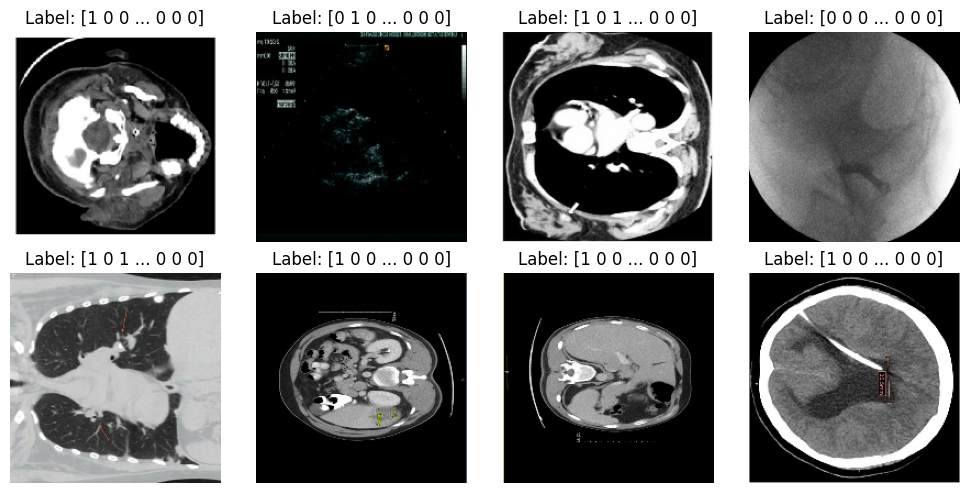

In [56]:
# Get the first batch from the training dataset
train_batch = next(iter(trainDS))

# Extract the images and labels from the batch
images, labels = train_batch

# Plot the images and their labels
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    # Plot the image
    ax.imshow(images[i])
    ax.axis('off')
    # Set the title to the corresponding label
    label = labels[i].numpy()
    ax.set_title(f'Label: {label}')


plt.tight_layout()
plt.show()

In [57]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)

def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)

def conv_mixer_block(x, filters: int, kernel_size: int):
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)
    return x

def get_conv_mixer_256_8(image_size=image_size, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=num_classes):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    # Change the output layer activation function to sigmoid
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

In [63]:
def run_experiment(model):
    optimizer = keras.optimizers.Adam(
        learning_rate=learning_rate
    )

    # Apply weight decay manually
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.keras"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
    )

    history = model.fit(
        trainDS,
        validation_data=validDS,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    # _, accuracy = model.evaluate(test_dataset)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [ ]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/2
2235/8764 [======>.......................] - ETA: 54:21 - loss: 0.0265 - accuracy: 0.4178 - precision_1: 0.0764 - recall_1: 0.1333 - auc_1: 0.7831

In [61]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

Even though we did not train the network to convergence, we can notice that different patches show different patterns. Some share similarity with others while some are very different. These visualizations are more salient with larger image sizes.

Similarly, we can visualize the raw convolution kernels. This can help us understand the patterns to which a given kernel is receptive.

In [ ]:
# First, print the indices of the convolution layers that are not
# pointwise convolutions.
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)


In [ ]:
test_data_dir = "../Test"

# Get list of filenames in the directory
test_paths = os.listdir(test_data_dir)

# Join the directory and filenames to get the full path
test_paths = [os.path.join(test_data_dir, filename) for filename in test_paths]

test_img = tf.data.Dataset.from_tensor_slices(test_paths)
test_img = test_img.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_img = test_img.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
test_img = test_img.prefetch(tf.data.AUTOTUNE)

In [ ]:
val_loss, val_acc = model.evaluate(validDS, steps=VALIDATION_STEPS, verbose=1)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

In [ ]:
# Generate predictions for the test data
print("[INFO] generating predictions...")
y_pred = conv_mixer_model.predict(test_img, verbose=1)

# Get the labels corresponding to the highest predicted probabilities
y_pred_labels = mlb.inverse_transform((y_pred > 0.5).astype(int))

In [ ]:
# Remove duplicate labels and limit to maximum of 100 labels per image
y_pred_labels_unique = []
for labels in y_pred_labels:
    unique_labels = []
    for label in labels:
        if label not in unique_labels and len(unique_labels) < 100:
            unique_labels.append(label)
    y_pred_labels_unique.append(unique_labels)

In [ ]:
# Save the predictions to a CSV file
print("[INFO] saving predictions...")
results = []
for i in range(len(test_paths)):
    filename = os.path.splitext(os.path.basename(test_paths[i]))[0]
    labels = ";".join(y_pred_labels_unique[i])
    results.append([filename + "|" + labels])
results_df = pd.DataFrame(results, columns=None)
results_df.to_csv('taskA_N2RjY_run2.csv', index=False, header=False)

In [ ]:
import pandas as pd

# Read the CSV file into a dataframe
results_df = pd.read_csv('taskA_N2RjY_run2.csv', header=None)

# Display the first few rows of the dataframe
results_df.head()